In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Linear regression using the Normal Equation

θ = (X⊺X )^(-1). (X⊺. y)

In this equation:
• θ is the value of θ that minimizes the cost function.
• y is the vector of target values containing y(1) to y(m).

In [2]:
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

[0, 2, 0, 15]

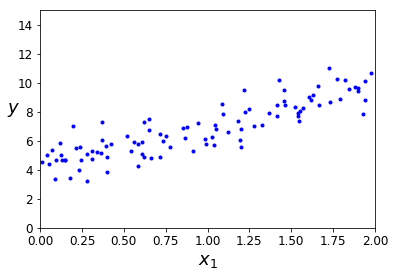

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])


In [4]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
X_b

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788],
       [1.        , 1.19731697],
       [1.        , 0.31203728],
       [1.        , 0.31198904],
       [1.        , 0.11616722],
       [1.        , 1.73235229],
       [1.        , 1.20223002],
       [1.        , 1.41614516],
       [1.        , 0.04116899],
       [1.        , 1.9398197 ],
       [1.        , 1.66488528],
       [1.        , 0.42467822],
       [1.        , 0.36364993],
       [1.        , 0.36680902],
       [1.        , 0.60848449],
       [1.        , 1.04951286],
       [1.        , 0.86389004],
       [1.        , 0.58245828],
       [1.        , 1.22370579],
       [1.        , 0.27898772],
       [1.        , 0.5842893 ],
       [1.        , 0.73272369],
       [1.        , 0.91213997],
       [1.        , 1.57035192],
       [1.        , 0.39934756],
       [1.        , 1.02846888],
       [1.        , 1.18482914],
       [1.        , 0.09290083],
       [1.

In [6]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [7]:
>>> X_new = np.array([[0], [2]])
>>> X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
>>> y_predict = X_new_b.dot(theta_best)
>>> y_predict

array([[4.21509616],
       [9.75532293]])

In [8]:
X_new

array([[0],
       [2]])

In [9]:
X_new_b

array([[1., 0.],
       [1., 2.]])

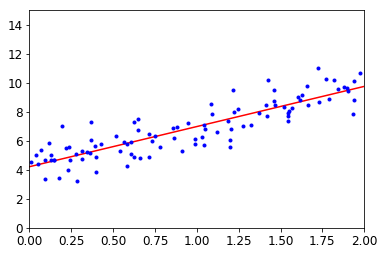

In [10]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

Performing Linear Regression using Scikit-Learn

In [11]:
>>> from sklearn.linear_model import LinearRegression
>>> lin_reg = LinearRegression()
>>> lin_reg.fit(X, y)
>>> lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [12]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The LinearRegression class is based on the scipy.linalg.lstsq() function (the
name stands for “least squares”), which you could call directly:

In [14]:
>>> theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
>>> theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes    $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the pseudoinverse of $\mathbf{X}$  (specifically,
the Moore-Penrose inverse). You can use np.linalg.pinv() to compute the
pseudoinverse directly:

In [15]:
>>> np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

The pseudoinverse itself is computed using a standard matrix factorization technique
called Singular Value Decomposition (SVD) that can decompose the training set
matrix X into the matrix multiplication of three matrices U Σ V⊺ (see
numpy.linalg.svd()).

The Normal Equation computes the inverse of $\mathbf{X}^+\mathbf{ }$ X, which is an (n + 1) × (n + 1)
matrix (where n is the number of features). The computational complexity of inverting
such a matrix is typically about O(n^2.4) to O(n^3), depending on the implementation .

The SVD approach used by Scikit-Learn’s LinearRegression class is about O(n^2)

Both the Normal Equation and the SVD approach get very slow
when the number of features grows large (e.g., 100,000). On the
positive side, both are linear with regard to the number of instances
in the training set (they are O(m)), so they handle large training
sets efficiently, provided they can fit in memory.

look at a very different way to train a Linear Regression model, which is
better suited for cases where there are a large number of features or too many training
instances to fit in memory


## Gradient Descent
Gradient Descent is a generic optimization algorithm capable of finding optimal solutions
to a wide range of problems. The general idea of Gradient Descent is to tweak
parameters iteratively in order to minimize a cost function.

An important parameter in Gradient Descent is the size of the steps, determined by
the learning rate hyperparameter. If the learning rate is too small, then the algorithm
will have to go through many iterations to converge, which will take a long time

On the other hand, if the learning rate is too high, you might jump across the valley
and end up on the other side, possibly even higher up than you were before. This
might make the algorithm diverge, with larger and larger values, failing to find a good
solution.

Finally, not all cost functions look like nice, regular bowls. There may be holes, ridges,
plateaus, and all sorts of irregular terrains, making convergence to the minimum difficult.

the MSE cost function for a Linear Regression model happens to be a
convex function, which means that if you pick any two points on the curve, the line
segment joining them never crosses the curve. This implies that there are no local
minima, just one global minimum. It is also a continuous function with a slope that
never changes abruptly.3 These two facts have a great consequence: Gradient Descent
is guaranteed to approach arbitrarily close the global minimum
#### When using Gradient Descent, you should ensure that all features have a similar scale (e.g., using Scikit-Learn’s StandardScaler class), or else it will take much longer to converge

training a model means searching for a
combination of model parameters that minimizes a cost function (over the training
set). It is a search in the model’s parameter space: the more parameters a model has,
the more dimensions this space has, and the harder the search is: searching for a needle
in a 300-dimensional haystack is much trickier than in 3 dimensions. Fortunately,
since the cost function is convex in the case of Linear Regression, the needle is simply
at the bottom of the bowl

### Batch Gradient Descent

In [16]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [17]:
theta

array([[4.21509616],
       [2.77011339]])

To find a good learning rate(eta), you can use grid search.

You may wonder how to set the number of iterations. If it is too low, you will still be
far away from the optimal solution when the algorithm stops; but if it is too high, you
will waste time while the model parameters do not change anymore. A simple solution
is to set a very large number of iterations but to interrupt the algorithm when the
gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny
number ϵ (called the tolerance)—because this happens when Gradient Descent has
(almost) reached the minimum.

#### Convergence Rate
When the cost function is convex and its slope does not change abruptly (as is the
case for the MSE cost function), Batch Gradient Descent with a fixed learning rate
will eventually converge to the optimal solution, but you may have to wait a while: it
can take O(1/ϵ) iterations to reach the optimum within a range of ϵ, depending on the
shape of the cost function. If you divide the tolerance by 10 to have a more precise
solution, then the algorithm may have to run about 10 times longer.

### Stochastic Gradient Descent

Stochastic Gradient Descent picks a
random instance in the training set at every step and computes the gradients based
only on that single instance. Obviously, working on a single instance at a time makes
the algorithm much faster because it has very little data to manipulate at every iteration.
It also makes it possible to train on huge training sets, since only one instance
needs to be in memory at each iteration.

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much
less regular than Batch Gradient Descent: instead of gently decreasing until it reaches
the minimum, the cost function will bounce up and down, decreasing only on average.Over time it will end up very close to the minimum, but once it gets there it will
continue to bounce around, never settling down . So once the algorithm
stops, the final parameter values are good, but not optimal.

When the cost function is very irregular , this can actually help the
algorithm jump out of local minima, so Stochastic Gradient Descent has a better
chance of finding the global minimum than Batch Gradient Descent does.Therefore, randomness is good to escape from local optima, but bad because it means
that the algorithm can never settle at the minimum.

One solution to this dilemma is
to gradually reduce the learning rate. The steps start out large (which helps make
quick progress and escape local minima), then get smaller and smaller, allowing the
algorithm to settle at the global minimum. This process is akin to simulated annealing.

The function that determines the learning rate at each
iteration is called the learning schedule. If the learning rate is reduced too quickly, you
may get stuck in a local minimum, or even end up frozen halfway to the minimum. If
the learning rate is reduced too slowly, you may jump around the minimum for a
long time and end up with a suboptimal solution if you halt training too early.

In [19]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters
def learning_schedule(t):
    return t0 / (t + t1)
theta = np.random.randn(2,1) # random initialization
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

By convention we iterate by rounds of m iterations; each round is called an epoch.
While the Batch Gradient Descent code iterated 1,000 times through the whole training
set, this code goes through the training set only 50 times and reaches a pretty
good solution:

In [20]:
theta


array([[4.18475289],
       [2.73036719]])

When using Stochastic Gradient Descent, the training instances
must be independent and identically distributed (IID) to ensure
that the parameters get pulled toward the global optimum, on average.
A simple way to ensure this is to shuffle the instances during
training (e.g., pick each instance randomly, or shuffle the training
set at the beginning of each epoch). If you do not shuffle the
instances—for example, if the instances are sorted by label—then
SGD will start by optimizing for one label, then the next, and so on,
and it will not settle close to the global minimum.

In [21]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.22609703]), array([2.79227913]))

### Mini-batch Gradient Descent

at each step, instead of computing the gradients based on the full training set
(as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD
computes the gradients on small random sets of instances called mini-batches. The
main advantage of Mini-batch GD over Stochastic GD is that you can get a performance
boost from hardware optimization of matrix operations, especially when using
GPUs.

The algorithm’s progress in parameter space is less erratic than with Stochastic GD,
especially with fairly large mini-batches. As a result, Mini-batch GD will end up walking
around a bit closer to the minimum than Stochastic GD—but it may be harder for
it to escape from local minima (in the case of problems that suffer from local minima,
unlike Linear Regression)

## Polynomial Regression
What if your data is more complex than a straight line? Surprisingly, you can use a
linear model to fit nonlinear data. A simple way to do this is to add powers of each
feature as new features, then train a linear model on this extended set of features. This
technique is called Polynomial Regression

[-3, 3, 0, 10]

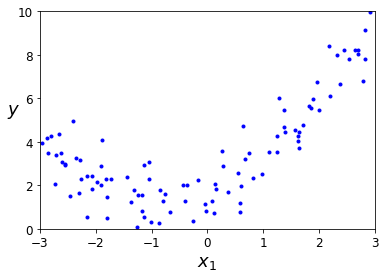

In [23]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

In [24]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [25]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [26]:
lin_reg = LinearRegression()
>>> lin_reg.fit(X_poly, y)
>>> lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

when there are multiple features, Polynomial Regression is capable of finding
relationships between features (which is something a plain Linear Regression
model cannot do). This is made possible by the fact that PolynomialFeatures also
adds all combinations of features up to the given degree.For example, if there were
two features a and b, PolynomialFeatures with degree=3 would not only add the
features a^2, a^3, b^2, and b^3, but also the combinations ab, (a^2)b, and ab^2

PolynomialFeatures(degree=d) transforms an array containing n
features into an array containing (n + d)! / d!n! features, where n! is
the factorial of n, equal to 1 × 2 × 3 × ⋯ × n. Beware of the combinatorial
explosion of the number of features!

## Learning Curves
This high-degree Polynomial Regression model is severely overfitting the training
data, while the linear model is underfitting it.

use cross-validation to get an estimate of a model’s generalization
performance. If a model performs well on the training data but generalizes poorly
according to the cross-validation metrics, then your model is overfitting. If it performs
poorly on both, then it is underfitting. This is one way to tell when a model is
too simple or too complex.

Another way to tell is to look at the learning curves: these are plots of the model’s performance
on the training set and the validation set as a function of the training set
size (or the training iteration). To generate the plots, train the model several times on
different sized subsets of the training set.

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)

[0, 80, 0, 3]

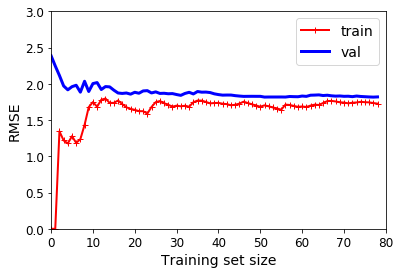

In [31]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3]) 

These learning curves are typical of a model that’s underfitting. Both curves have
reached a plateau; they are close and fairly high

This model that’s underfitting deserves a bit of explanation. First, let’s look at the performance
on the training data: when there are just one or two instances in the training
set, the model can fit them perfectly, which is why the curve starts at zero. But as
new instances are added to the training set, it becomes impossible for the model to fit
the training data perfectly, both because the data is noisy and because it is not linear
at all. So the error on the training data goes up until it reaches a plateau, at which
point adding new instances to the training set doesn’t make the average error much
better or worse. Now let’s look at the performance of the model on the validation
data. When the model is trained on very few training instances, it is incapable of generalizing
properly, which is why the validation error is initially quite big. Then, as the model is shown more training examples, it learns, and thus the validation error
slowly goes down. However, once again a straight line cannot do a good job modeling
the data, so the error ends up at a plateau, very close to the other curve.

#### If your model is underfitting the training data, adding more training  examples will not help. You need to use a more complex model or come up with better features.

[0, 80, 0, 3]

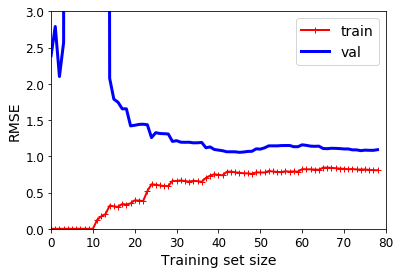

In [32]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])

The error on the training data is much lower than with the Linear Regression
model.
There is a gap between the curves. This means that the model performs significantly
better on the training data than on the validation data, which is the hallmark
of an overfitting model. If you used a much larger training set, however, the
two curves would continue to get closer.
#### One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error
#### Increasing a model’s complexity will typically increase its variance and reduce its bias.Conversely, reducing a model’s complexity increases its bias and reduces its variance.This is why it is called a trade-off.

## Regularized Linear Models

A simple way to regularize a polynomial model is to reduce
the number of polynomial degrees.
### Ridge Regression
Ridge Regression (also called Tikhonov regularization) is a regularized version of Linear
Regression: a regularization term equal to αΣi = 1
n θi^2 is added to the cost function.

This forces the learning algorithm to not only fit the data but also keep the model
weights as small as possible. Note that the regularization term should only be added
to the cost function during training. Once the model is trained, you want to use the
unregularized performance measure to evaluate the model’s performance

The hyperparameter α controls how much you want to regularize the model. If α = 0,
then Ridge Regression is just Linear Regression. If α is very large, then all weights end
up very close to zero and the result is a flat line going through the data’s mean

the bias term θ0 is not regularized (the sum starts at i = 1, not 0).

It is important to scale the data (e.g., using a StandardScaler)
before performing Ridge Regression, as it is sensitive to the scale of
the input features. This is true of most regularized models.

In [40]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [41]:
>>> from sklearn.linear_model import Ridge
>>> ridge_reg = Ridge(alpha=1, solver="cholesky")
>>> ridge_reg.fit(X, y)
>>> ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [42]:
ridge_reg1 = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg1.fit(X, y)
ridge_reg1.predict([[1.5]])

array([[1.5507201]])

In [43]:
>>> sgd_reg = SGDRegressor(penalty="l2",max_iter=1000,tol=1e-3)
>>> sgd_reg.fit(X, y.ravel())
>>> sgd_reg.predict([[1.5]])

array([1.46543286])

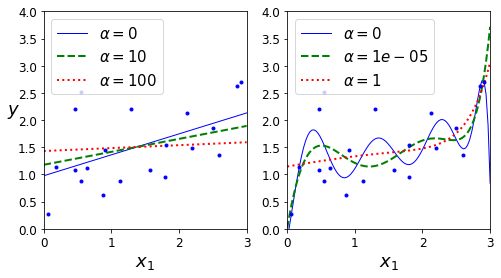

In [45]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

The penalty hyperparameter sets the type of regularization term to use. Specifying
"l2" indicates that you want SGD to add a regularization term to the cost function
equal to half the square of the ℓ2 norm of the weight vector: this is simply Ridge
Regression.
### Lasso Regression

D:\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


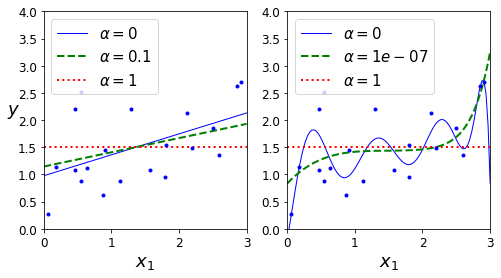

In [46]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

An important characteristic of Lasso Regression is that it tends to eliminate the
weights of the least important features (i.e., set them to zero).

Lasso Regression automatically performs feature selection and
outputs a sparse model (i.e., with few nonzero feature weights).

In [47]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

Note that you could instead use SGDRegressor(penalty="l1").

The Lasso cost function is not differentiable at θi = 0 (for i = 1, 2, ⋯, n), but Gradient
Descent still works fine if you use a subgradient vector g instead when any θi = 0.

#### There are two main differences with Lasso from Ridge . 
First in Ridge, the gradients
get smaller as the parameters approach the global optimum, so Gradient Descent naturally
slows down, which helps convergence (as there is no bouncing around) But in Lasso Gradient Descent takes to optimize
some model parameters that were initialized around θ:
then rolls down the gutter and
ends up bouncing around the global optimum . 

Second,the optimal parameters get closer and closer to
the origin when you increase α, but they never get eliminated entirely.But in lasso if we
increased α, the global optimum would move left and may get eliminated

#### To avoid Gradient Descent from bouncing around the optimum at the end when using Lasso, you need to gradually reduce the learning rate during training (it will still bounce around the optimum, but the steps will get smaller and smaller, so it will converge).

### Elastic Net
Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The
regularization term is a simple mix of both Ridge and Lasso’s regularization terms,
and you can control the mix ratio r. When r = 0, Elastic Net is equivalent to Ridge
Regression, and when r = 1, it is equivalent to Lasso Regression

Ridge is a good
default, but if you suspect that only a few features are useful, you should prefer Lasso
or Elastic Net because they tend to reduce the useless features’ weights down to zero.

Elastic Net is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of
training instances or when several features are strongly correlated.

In [48]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

A very different way to regularize iterative learning algorithms such as Gradient
Descent is to stop training as soon as the validation error reaches a minimum. This is
called early stopping.

As the
epochs go by the algorithm learns, and its prediction error (RMSE) on the training
set goes down, along with its prediction error on the validation set. After a while
though, the validation error stops decreasing and starts to go back up. This indicates
that the model has started to overfit the training data. With early stopping you just
stop training as soon as the validation error reaches the minimum.

With Stochastic and Mini-batch Gradient Descent, the curves are
not so smooth, and it may be hard to know whether you have
reached the minimum or not. One solution is to stop only after the
validation error has been above the minimum for some time (when
you are confident that the model will not do any better), then roll
back the model parameters to the point where the validation error
was at a minimum.

In [49]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [50]:
from copy import deepcopy
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

Text(0, 0.5, 'RMSE')

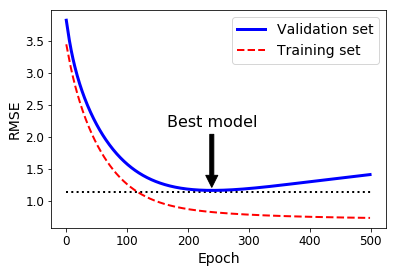

In [51]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

## Logistic regression
Logistic Regression (also called Logit Regression) is commonly
used to estimate the probability that an instance belongs to a particular class.If the estimated probability is greater
than 50%, then the model predicts that the instance belongs to that class (called the
positive class, labeled “1”), and otherwise it predicts that it does not (i.e., it belongs to
the negative class, labeled “0”). This makes it a binary classifier.

The bad news is that there is no known closed-form equation to compute the value of
θ that minimizes this cost function (there is no equivalent of the Normal Equation).
The good news is that this cost function is convex, so Gradient Descent (or any other
optimization algorithm) is guaranteed to find the global minimum.

Once you have the gradient vector containing all
the partial derivatives, you can use it in the Batch Gradient Descent algorithm. For Stochastic GD you
would take one instance at a time, and for Mini-batch GD you would use a minibatch
at a time.



[-10, 10, -0.1, 1.1]

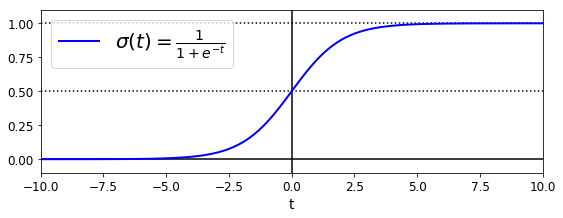

In [52]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])

In [53]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [54]:
X = iris["data"][:, 3:] # petal width
>>> y = (iris["target"] == 2).astype(np.int) # 1 if Iris virginica, else 0

In [55]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

[0, 3, -0.02, 1.02]

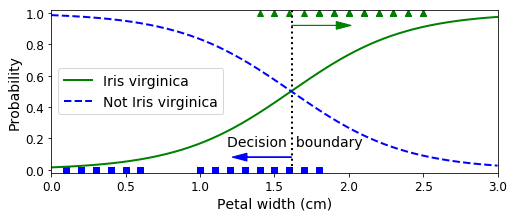

In [56]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

there is a decision
boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal
width is higher than 1.6 cm, the classifier will predict that the flower is an Iris virginica,
and otherwise it will predict that it is not (even if it is not very confident

In [57]:
decision_boundary


array([1.61561562])

In [58]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

[2.9, 7, 0.8, 2.7]

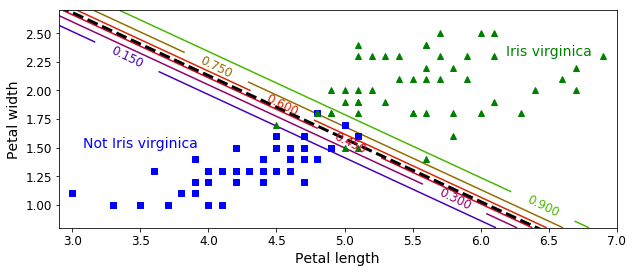

In [59]:

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

The dashed line
represents the points where the model estimates a 50% probability: this is the model’s
decision boundary. Note that it is a linear boundary.16 Each parallel line represents the
points where the model outputs a specific probability, from 15% (bottom left) to 90%
(top right). All the flowers beyond the top-right line have an over 90% chance of
being Iris virginica, according to the model.
#### Just like the other linear models, Logistic Regression models can be regularized  ℓ1 or ℓ2 penalties. Scikit-Learn actually adds an ℓ2 penalty by default. 
The hyperparameter controlling the regularization strength of a
Scikit-Learn LogisticRegression model is not alpha (as in other
linear models), but its inverse: C. The higher the value of C, the less
the model is regularized

## Softmax Regression
The Logistic Regression model can be generalized to support multiple classes directly,
without having to train and combine multiple binary classifiers This is called Softmax Regression, or Multinomial Logistic Regression.

when given an instance x, the Softmax Regression model first
computes a score sk(x) for each class k, then estimates the probability of each class by
applying the softmax function (also called the normalized exponential) to the scores.The function computes the exponential of
every score, then normalizes them (dividing by the sum of all the exponentials). The
scores are generally called logits or log-odds.

Just like the Logistic Regression classifier, the Softmax Regression classifier predicts
the class with the highest estimated probability (which is simply the class with the
highest score).

The Softmax Regression classifier predicts only one class at a time
(i.e., it is multiclass, not multioutput), so it should be used only
with mutually exclusive classes.

####  cross entropy, 
The objective is to have a model that estimates a high
probability for the target class (and consequently a low probability for the other
classes). Minimizing the cost function  called the cross entropy, 
should lead to this objective because it penalizes the model when it estimates
a low probability for a target class. Cross entropy is frequently used to measure how
well a set of estimated class probabilities matches the target classes.

#### important
Scikit-
Learn’s LogisticRegression uses one-versus-the-rest by default when you train it on
more than two classes, but you can set the multi_class hyperparameter to "multino
mial" to switch it to Softmax Regression. You must also specify a solver that supports
Softmax Regression, such as the "lbfgs" solver  It also applies ℓ2 regularization by default, which you can control using
the hyperparameter C:


In [60]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [61]:
softmax_reg.predict([[5, 2]])

array([2])

In [62]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

[0, 7, 0, 3.5]

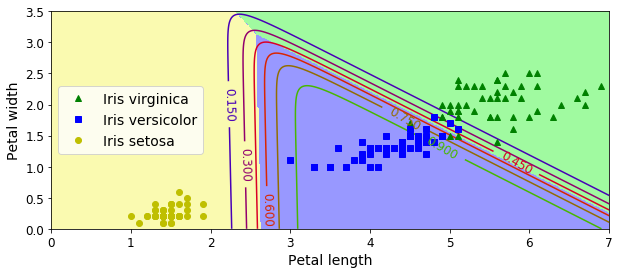

In [63]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])